<a href="https://colab.research.google.com/github/miltiadiss/Decision-Theory/blob/main/TSLA_stock_price_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Decision Theory**
#**Project 1: TSLA stock closing price prediction**

In [72]:
from google.colab import drive
drive.mount('/content/drive')

import os
desired_directory = '/content/drive/MyDrive/alphavantage' #define current directory in google drive
os.chdir(desired_directory)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [73]:
import requests

#API_KEY = YZFYJ9DASTWXPXOS
#STOCK_SYMBOL = TSLA

url = 'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=TSLA&outputsize=full&apikey=YZFYJ9DASTWXPXOS'
r = requests.get(url)
json_data = r.json()

#print(json_data)

The data that we will be using contain the TSLA stock closing prices from 2010-06-29 until 2024-10-31. The training test will contain data from 2010-06-29 until 2023-12-31 and the validation test after the training process will contain data from 2024-01-01 until 2024-10-31. So all the predictions will be made on new data that will start from date 2024-11-01.

In [74]:
import json
import csv
import pandas as pd
from scipy.ndimage import gaussian_filter1d
import numpy as np
import matplotlib.pyplot as plt

# Extract "Time Series (Daily)" part from JSON
time_series = json_data.get("Time Series (Daily)", {})

# Prepare data for CSV
csv_data = [("Date", "Close")]  # Header for CSV file

# Loop through each date and get the "close" price
for date, daily_data in time_series.items():
    close_price = daily_data.get("4. close", None)
    if close_price:
        csv_data.append((date, close_price))

# Write data to CSV file
csv_file = 'close_prices.csv'
with open(csv_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(csv_data)

print(f"Data saved to {csv_file}")

# Read CSV file and store the data in a DataFrame
df = pd.read_csv('close_prices.csv', parse_dates=['Date'])
df = df.sort_values(by='Date')  # Sorting by 'Date'

Data saved to close_prices.csv


##**Data Preprocessing**

We will first use a Gaussian Filter in order to remove the outliers and denoise the data timeseries.

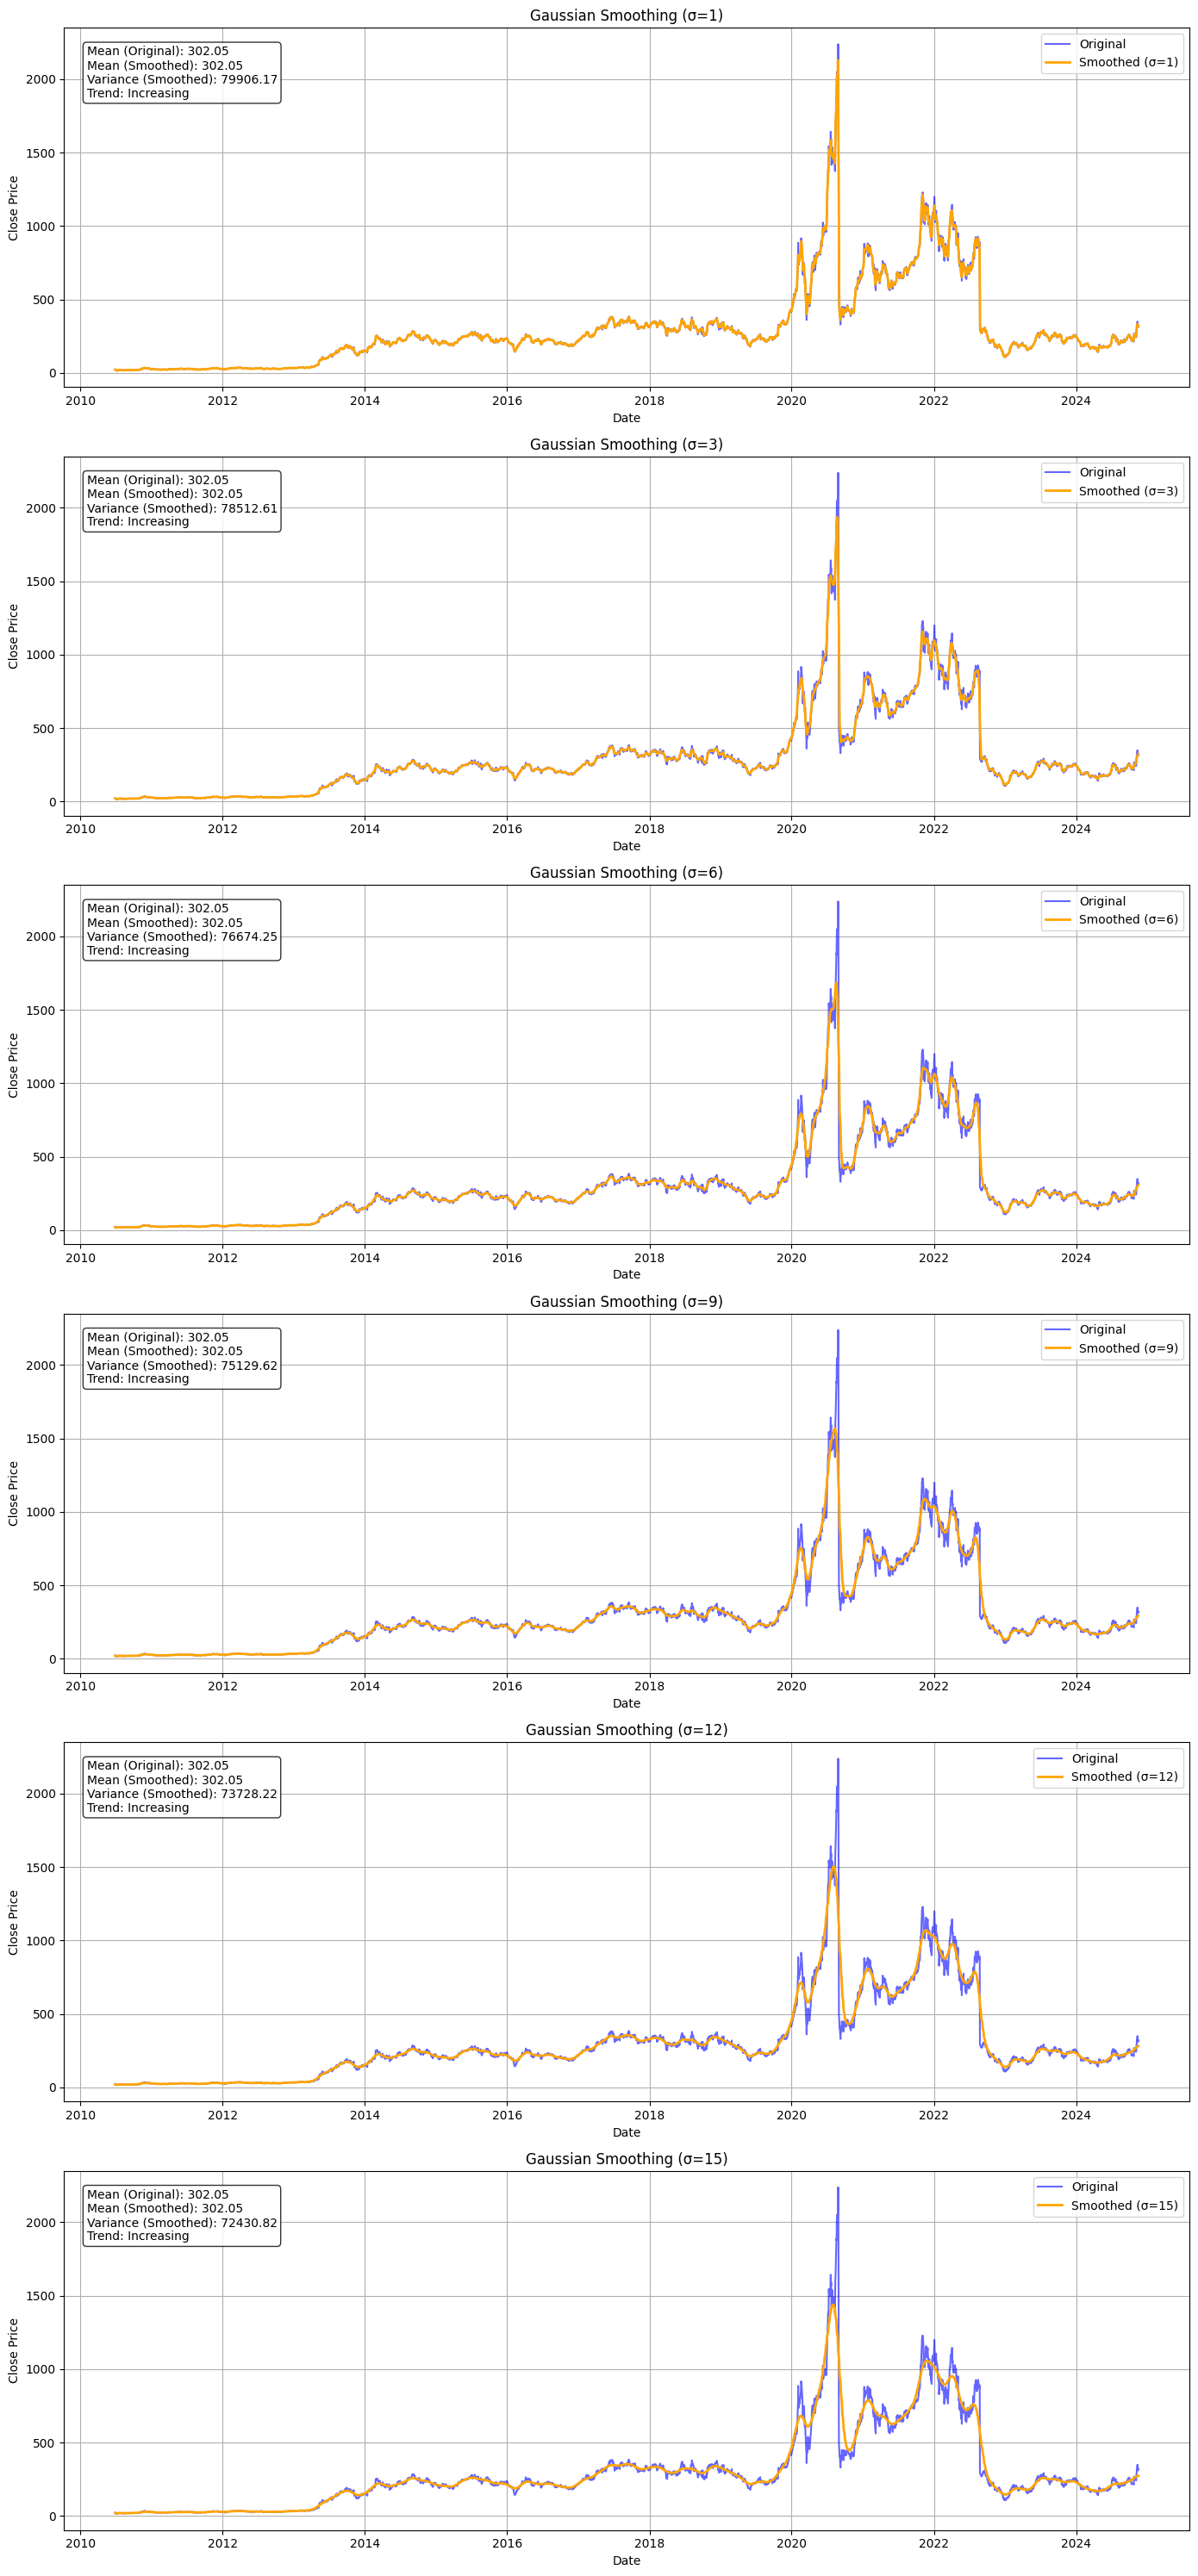

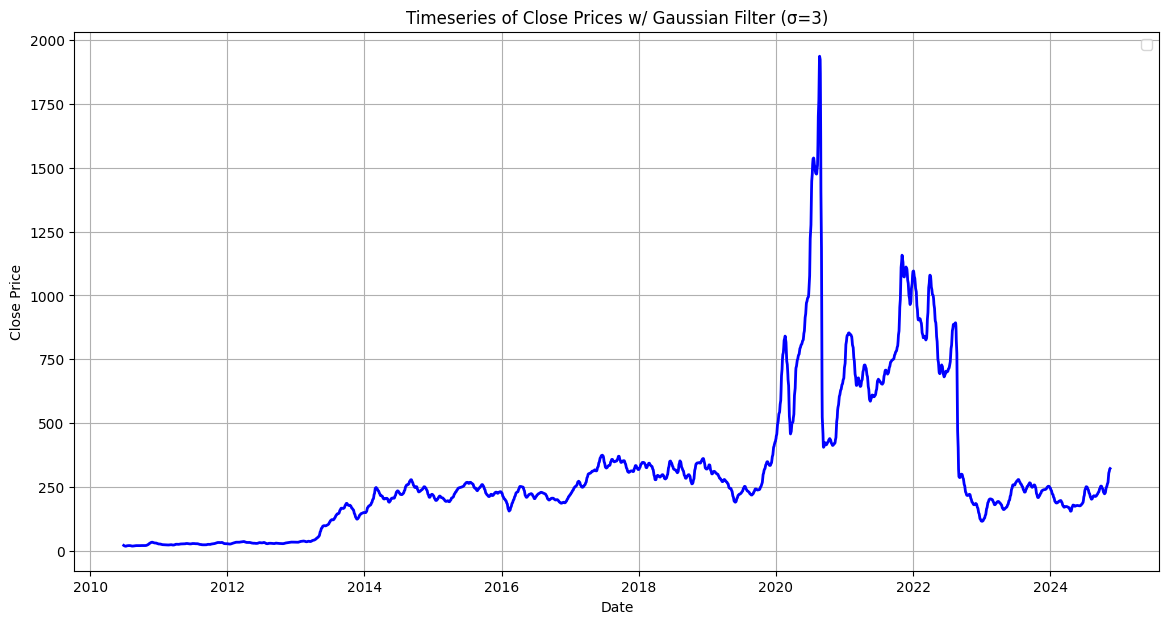

In [75]:
from scipy.stats import linregress

# Visualize original and smoothed timeseries for different values of sigma
sigma_values = [1, 3, 6, 9, 12, 15]
fig, axes = plt.subplots(len(sigma_values), 1, figsize=(14, 5 * len(sigma_values)))

for i, sigma in enumerate(sigma_values):
    # Apply Gaussian filter
    smoothed_close = gaussian_filter1d(df['Close'], sigma=sigma)

    # Compute statistics
    mean_original = np.mean(df['Close'])
    mean_smoothed = np.mean(smoothed_close)
    variance_smoothed = np.var(smoothed_close)

    # Calculate trend using linear regression on the smoothed data
    slope, intercept, _, _, _ = linregress(range(len(smoothed_close)), smoothed_close)
    trend = "Increasing" if slope > 0 else "Decreasing" if slope < 0 else "Flat"

    # Plot original and smoothed data
    axes[i].plot(df['Date'], df['Close'], label='Original', color='blue', linewidth=1.5, alpha=0.6)
    axes[i].plot(df['Date'], smoothed_close, label=f'Smoothed (σ={sigma})', color='orange', linewidth=2)

    # Display statistics on the plot
    stats_text = (
        f"Mean (Original): {mean_original:.2f}\n"
        f"Mean (Smoothed): {mean_smoothed:.2f}\n"
        f"Variance (Smoothed): {variance_smoothed:.2f}\n"
        f"Trend: {trend}"
    )
    axes[i].text(0.02, 0.95, stats_text, transform=axes[i].transAxes, fontsize=10, va='top', bbox=dict(boxstyle="round", facecolor="white", alpha=0.8))

    # Formatting the subplot
    axes[i].set_title(f'Gaussian Smoothing (σ={sigma})')
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel('Close Price')
    axes[i].legend()
    axes[i].grid(True)

plt.tight_layout()
plt.show()

# Apply Gaussian Filter with the optimal sigma value
sigma = 3
df['Close'] = gaussian_filter1d(df['Close'], sigma=sigma)

# Plot the smoothed timeseries
plt.figure(figsize=(14, 7))
plt.plot(df['Date'], df['Close'], color='blue', linewidth=2)

plt.title(f'Timeseries of Close Prices w/ Gaussian Filter (σ={sigma})')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()

### **Observation**
TSLA stock closing prices exhibit a strong upward trend starting around 2019, which peaks in late 2021 before experiencing a significant drop in 2022. There are periods of high volatility, particularly during the 2020-2022 period, with sharp spikes and drops. This suggests that the stock had frequent fluctuations. After the significant drop in 2022, the closing prices seem to have stabilized, hovering around a lower price range in 2023-2024. Overall, this indicates that the target variable (closing stock price) has a strong dependency on recent, short-term changes rather than on smoothed, long-term trends. In essence, TSLA's price dynamics are better captured by a model that considers recent day-to-day variations, as these fluctuations hold more predictive value than a smoothed view of weekly trends, which would obscure the nuanced daily changes. **Therefore, we will choose to use the daily closing prices as features for the training of the model rather than the weekly averages.**

Particularly for year 2024 the data appear more stable compared to previous years, with no significant upward or downward trends. **Thus, a Linear Regression could be more adequate for making predictions in data from 2024 of the validation set than a Polynomial Regression.** Higher-degree polynomials are at risk of overfitting, since the model is trained on the 2010-2023 data, which have more spikes and dips than the 2024 data.

**Finally, Linear Regression might generalize better since it won't overfit to the past spikes and dips and it could capture a smooth trend if the testing data behave similarly to validation data.** On the other hand, Polynomial Regression would be less adaptable if testing data turn out to be more stable just like validaton data.






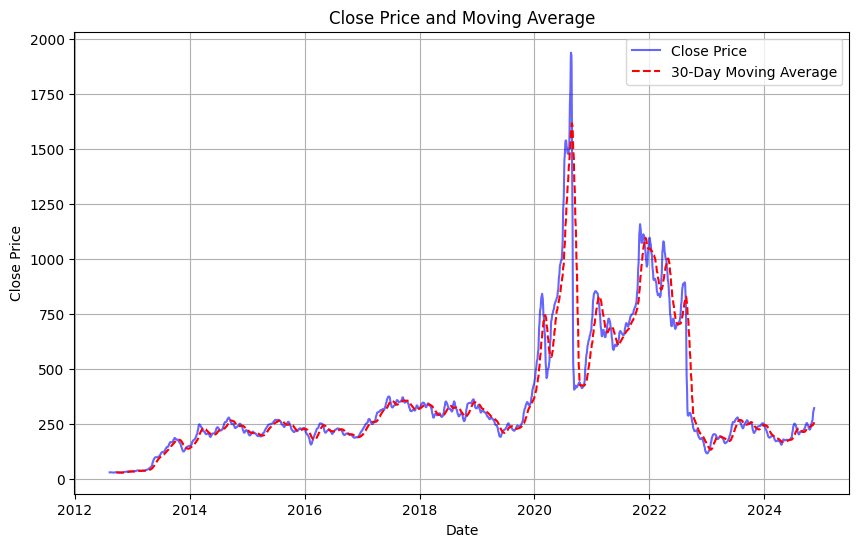

In [128]:
# Calculate Simple Moving Average (SMA) with window size 30 days
SMA_30 = df['Close'].rolling(window=30).mean()

# Plot Close Prices with Moving Average
plt.figure(figsize=(10, 6))
plt.plot(df['Date'], df['Close'], label='Close Price', color='blue', alpha=0.6)
plt.plot(df['Date'], SMA_30, label='30-Day Moving Average', color='red', linestyle='--')
plt.title("Close Price and Moving Average")
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()

###**Observation**

<Figure size 1000x800 with 0 Axes>

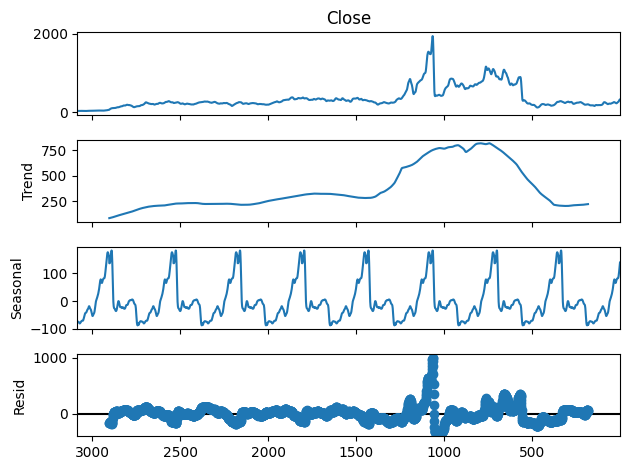

In [126]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Seasonal Decomposition
decomposition = seasonal_decompose(df['Close'], model='additive', period=365)  # Use period=365 for yearly seasonality

# Plot decomposition
plt.figure(figsize=(10, 8))
decomposition.plot()
plt.show()

###**Observation**

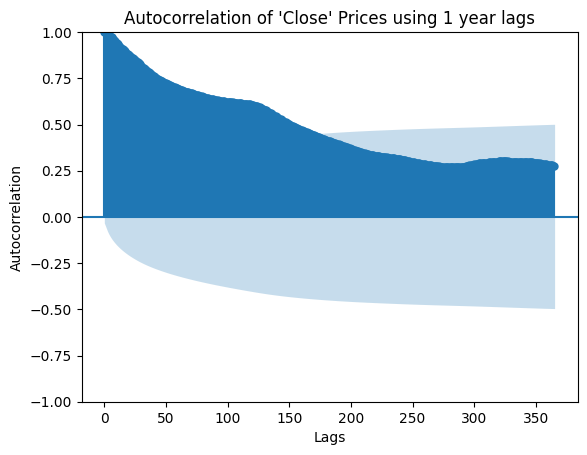

In [124]:
from statsmodels.graphics.tsaplots import plot_acf

# Create ACF plot to find correlation between closing prices for interval of 1 year
plot_acf(df['Close'], lags=365)
plt.title("Autocorrelation of 'Close' Prices using 1 year lags")
plt.xlabel("Lags")
plt.ylabel("Autocorrelation")
plt.show()

### **Observation**
We observe that the lagged features (daily closing prices) have a strong short-term correlation and there is no periodic trends such as weekly seasonability. Therfore, the lagged daily features will retain the fine-grained details that help capture these dependencies more accurately. With high ACF, sudden changes or trends in the daily prices (like upward or downward trends) are likely to carry forward. **Daily lagged values would capture these shifts more directly than weekly values, which tend to smooth over such changes, potentially missing short-term predictive information.**

#**Question A: Training, Validation and Testing of Linear Regression Model**


Model Parameters for N=1:
Bias: 0.4896
Weight for close_t-1: 0.9988806851263438
Model Equation:
Close_t = 0.4896197877636723 + (0.9988806851263438) * close_t-1

Model Parameters for N=2:
Bias: 0.6565
Weight for close_t-1: 1.9675429697285982
Weight for close_t-2: -0.9693204013822458
Model Equation:
Close_t = 0.6565210435915105 + (1.9675429697285982) * close_t-1 + (-0.9693204013822458) * close_t-2

Model Parameters for N=3:
Bias: 0.0382
Weight for close_t-1: 2.8947290236244556
Weight for close_t-2: -2.850936755120041
Weight for close_t-3: 0.9561165528767102
Model Equation:
Close_t = 0.038213227661799465 + (2.8947290236244556) * close_t-1 + (-2.850936755120041) * close_t-2 + (0.9561165528767102) * close_t-3

Model Parameters for N=4:
Bias: 0.0556
Weight for close_t-1: 3.7705524069090894
Weight for close_t-2: -5.462084684438903
Weight for close_t-3: 3.6070155444133603
Weight for close_t-4: -0.9156330554781569
Model Equation:
Close_t = 0.055633639899212994 + (3.7705524069090894) * close_t-

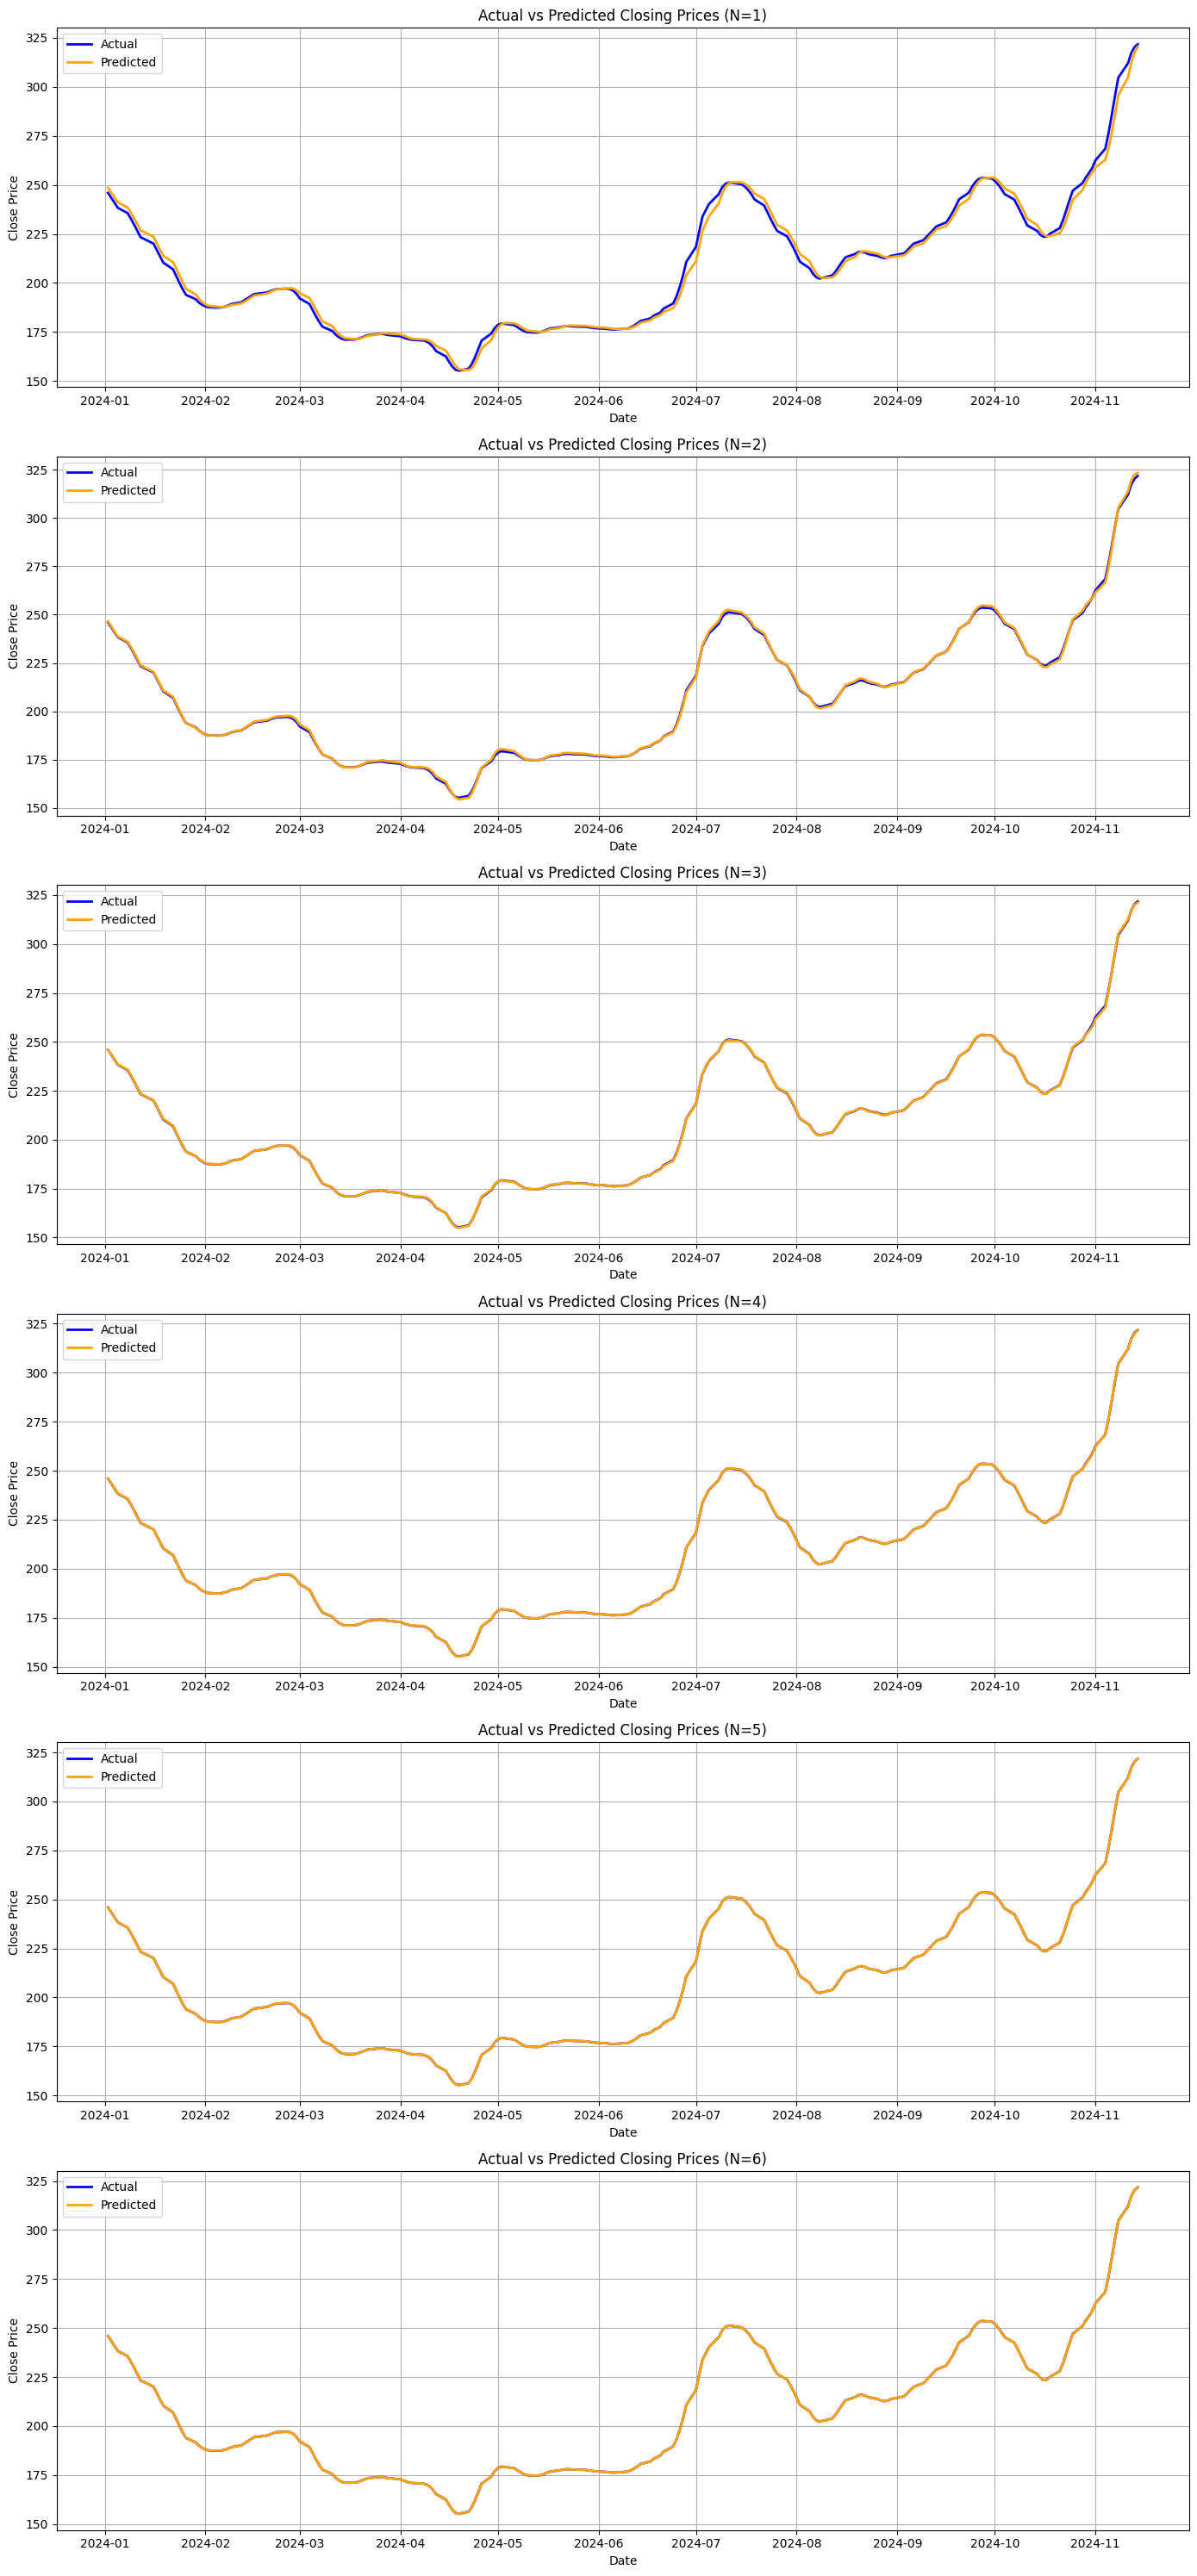

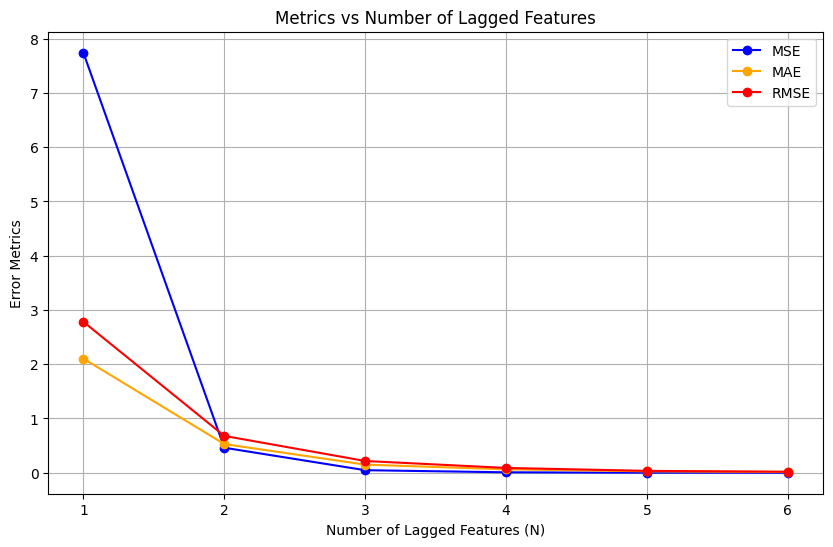

In [144]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Create a function that trains and evaluates the model for different amounts
# of lagged features and different DataFrames
def linear_regression_model(N, data):
    # Create N lagged features
    for i in range(1, N + 1):
        data[f'close_t-{i}'] = data['Close'].shift(i)

    # Drop NaN values
    data.dropna(inplace=True)

    # Create training set and validation set
    train_data = data[data['Date'] < '2024-01-01']  # Use previous years for training
    validation_data = data[data['Date'] >= '2024-01-01']  # Use year 2024 for validation

    # Prepare features (X) and target (y) for training and validation
    X_train = train_data[[f'close_t-{i}' for i in range(1, N + 1)]]
    y_train = train_data['Close']
    X_val = validation_data[[f'close_t-{i}' for i in range(1, N + 1)]]
    y_val = validation_data['Close']

    # Create and fit the Linear Regression model using the training set
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Make the prediction using the validation set
    y_pred = model.predict(X_val)

    # Evaluate the model metrics
    mae = mean_absolute_error(y_val, y_pred)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    mse = mean_squared_error(y_val, y_pred)

    # Get model parameters (weights and bias)
    weights = model.coef_
    bias = model.intercept_

    return mae, rmse, mse, y_val, y_pred, validation_data['Date'], weights, bias

# Plot the actual and predicted 'close' prices for the different values of lagged features and
# the initial DataFrame
num_tests = 6  # Testing from N = 1 to 6
fig, axes = plt.subplots(num_tests, 1, figsize=(14, 5 * num_tests))
results = []

for idx, N in enumerate(range(1, num_tests + 1)):
    mae, rmse, mse, y_val, y_pred, dates, weights, bias = linear_regression_model(N, df)  # Call the function here
    results.append((N, mae, rmse, mse))

    axes[idx].plot(dates, y_val, label='Actual', color='blue', linewidth=2)
    axes[idx].plot(dates, y_pred, label='Predicted', color='orange', linewidth=2)
    axes[idx].set_title(f'Actual vs Predicted Closing Prices (N={N})')
    axes[idx].set_xlabel('Date')
    axes[idx].set_ylabel('Close Price')
    axes[idx].legend()
    axes[idx].grid(True)

    # Print the model parameters
    print(f"\nModel Parameters for N={N}:")
    print(f"Bias: {bias:.4f}")
    equation = f"Close_t = {bias}"
    for i, coef in enumerate(weights):
        equation += f" + ({coef}) * close_t-{i+1}"
        print(f"Weight for close_t-{i+1}: {coef}")
    print("Model Equation:")
    print(equation)

results_df = pd.DataFrame(results, columns=['N', 'Mean Absolute Error', 'Root Mean Squared Error', 'Mean Squared Error'])
print('\nMetrics')
print(results_df)

plt.tight_layout()
plt.show()

# Plot Metrics vs Number of Lagged Features
plt.figure(figsize=(10, 6))
mse_values = results_df['Mean Squared Error']
mae_values = results_df['Mean Absolute Error']
rmse_values = results_df['Root Mean Squared Error']

plt.plot(range(1, num_tests + 1), mse_values, marker='o', linestyle='-', color='blue', label='MSE')
plt.plot(range(1, num_tests + 1), mae_values, marker='o', linestyle='-', color='orange', label='MAE')
plt.plot(range(1, num_tests + 1), rmse_values, marker='o', linestyle='-', color='red', label='RMSE')

plt.title('Metrics vs Number of Lagged Features')
plt.xlabel('Number of Lagged Features (N)')
plt.ylabel('Error Metrics')
plt.xticks(range(1, num_tests + 1))
plt.legend()
plt.grid(True)
plt.show()

###**Observation**
We can observe that there is a significant drop in all Error Metrics when moving from N=1 to N=2. This suggests that having at least two lagged features improves the model's predictive power substantially. After N=3 the Error Metrics begin to stabilize, showing minimal improvement as N increases. This indicates that adding more lagged features beyond 3-4 doesn't contribute much additional predictive power.This means that the optimal amount of lagged features is 3-4 and with these the model can be trained really efficiently. The usage of more lagged features (probably 5-6 or even more) could lead to overfitting. **In general, we can see that indeed the Linear Regression Model performs really well on the validation dataset, since the data show a stable and flat trend. Also, we can expect that the Polynomial Regression in Question B will have a poorer performance.**

So, we will use this version of the Linear Regression Model with 4 lagged features in order to predict the TSLA stock closing prices from 2024-11-01 until 2024-11-24.

In [106]:
# Function to predict close prices for new dates
def predict_close_price(df, weights, bias, start_date, num_days):
    predictions = []
    last_known_prices = df['Close'].values  # Last known 'close' prices

    # Get the last N close prices for initial prediction
    last_n_prices = last_known_prices[-N:]

    for _ in range(num_days):
        # Calculate predicted close price for the next day
        predicted_close = np.dot(last_n_prices[::-1], weights) + bias
        predictions.append(predicted_close)

        # Update the last N prices for the next prediction
        last_n_prices = np.append(last_n_prices[1:], predicted_close)

    return predictions

# Train the model with the best value of lagged features, which is N=3
N = 3
_, _, _, _, _, _, weights, bias = linear_regression_model(N, df)

# Predict the close price for the next day, which is 2024-11-15
start_date = '2024-11-15'
num_days = 1
next_day_prediction = predict_close_price(df, weights, bias, start_date, num_days)
print(f"Predicted close price for {start_date}: {next_day_prediction[0]:.2f} $\n")

Predicted close price for 2024-11-15: 321.65 $



In [107]:
# Make predictions starting for the next 15 days to see how the trend might evolve
num_days = 15
predictions = predict_close_price(df, weights, bias, start_date, num_days)

# Print the predictions with the requested format
for i, prediction in enumerate(predictions, start=1):
    print(f"Predicted close price for day {i} ({start_date} + {i-1} days): {prediction:.2f} $")

Predicted close price for day 1 (2024-11-15 + 0 days): 321.65 $
Predicted close price for day 2 (2024-11-15 + 1 days): 319.99 $
Predicted close price for day 3 (2024-11-15 + 2 days): 316.99 $
Predicted close price for day 4 (2024-11-15 + 3 days): 312.90 $
Predicted close price for day 5 (2024-11-15 + 4 days): 308.02 $
Predicted close price for day 6 (2024-11-15 + 5 days): 302.71 $
Predicted close price for day 7 (2024-11-15 + 6 days): 297.31 $
Predicted close price for day 8 (2024-11-15 + 7 days): 292.16 $
Predicted close price for day 9 (2024-11-15 + 8 days): 287.59 $
Predicted close price for day 10 (2024-11-15 + 9 days): 283.86 $
Predicted close price for day 11 (2024-11-15 + 10 days): 281.17 $
Predicted close price for day 12 (2024-11-15 + 11 days): 279.65 $
Predicted close price for day 13 (2024-11-15 + 12 days): 279.36 $
Predicted close price for day 14 (2024-11-15 + 13 days): 280.26 $
Predicted close price for day 15 (2024-11-15 + 14 days): 282.27 $


In [105]:
# Make predictions starting for the next 15 days to see how the trend might evolve
num_days = 15
predicted_prices = predict_close_price(df, weights, bias, start_date, num_days)

# Create a DataFrame for predicted prices with corresponding dates
predicted_dates = [pd.to_datetime(start_date) + pd.Timedelta(days=i) for i in range(num_days)]
predictions_df = pd.DataFrame({'Date': predicted_dates, 'Predicted Close': predicted_prices})
print(predictions_df)

# Combine predictions with the initial DataFrame
df_combined = pd.concat([df, predictions_df], ignore_index=True)

# Plot the actual and predicted 'close' prices for all days
fig, ax = plt.subplots(figsize=(14, 7))
ax.plot(df[df['Date'] >= '2024-01-01']['Date'], df[df['Date'] >= '2024-01-01']['Close'], label='Actual', color='blue', linewidth=2)
ax.plot(predictions_df['Date'], predictions_df['Predicted Close'], label='Predicted', color='orange', linestyle='-', linewidth=2)

# Set plot limits to show only year 2024 and onwards
ax.set_xlim([pd.to_datetime('2024-01-01'), predictions_df['Date'].max()])

ax.set_title('Predicted Closing Prices from 2024-11-01 until 2024-11-24')
ax.set_xlabel('Date')
ax.set_ylabel('Close Price')
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()

TypeError: predict_close_price() missing 1 required positional argument: 'degree'

###**Real TSLA stock closing prices from November 1st until November 24th**

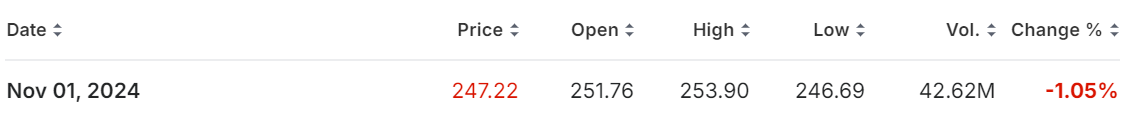

##**Conclusion**
We conclude that in terms of the **Linear Regression Model** the usage of **4 previous daily closing prices** as features works accurately enough for short-term predictions of brand new data, yet it fails to generalize well for long-term data.

For Question B we will be also using the daily closing prices as lagged features.

#**Question B: Training, Validation and Testing of Polynomial Regression Model**

The closing price movements are often non-linear in nature. A linear model assumes a consistent rate of change, which may not capture the complexities of TSLA price dynamics accurately. A polynomial model on the other hand, can capture these non-linear relationships by allowing the model to adjust more flexibly to changes in the trend. So we expect that the Polynomial Regression Model can achieve more accurate predictions if we find a moderate degree.

##**Using L1-Normalization**


Metrics for Polynomial Degree 1:
   N  Mean Absolute Error  Root Mean Squared Error  Mean Squared Error
0  1             2.096462                 2.784786            7.755033
1  2             0.564472                 0.738706            0.545686
2  3             0.646007                 0.847445            0.718163
3  4             0.695342                 0.911301            0.830469
4  5             0.574657                 0.758358            0.575107
5  6             0.490161                 0.673870            0.454101
6  7             0.496495                 0.699617            0.489464
7  8             0.535379                 0.755260            0.570418


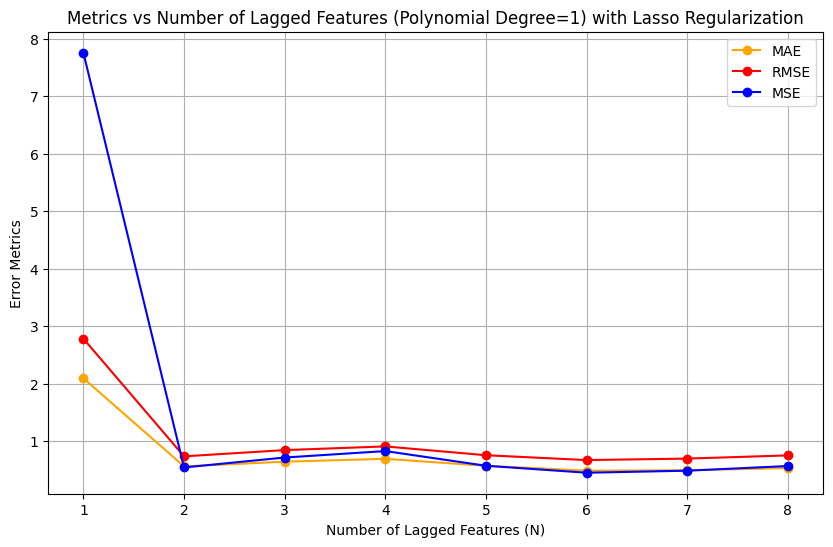


Metrics for Polynomial Degree 2:
   N  Mean Absolute Error  Root Mean Squared Error  Mean Squared Error
0  1             2.088429                 2.765805            7.649676
1  2             1.273558                 1.666886            2.778510
2  3             1.312353                 1.709386            2.922002
3  4             1.137588                 1.483810            2.201692
4  5             0.903798                 1.187493            1.410141
5  6             0.852371                 1.128142            1.272705
6  7             0.866074                 1.141729            1.303545
7  8             0.898740                 1.177431            1.386344


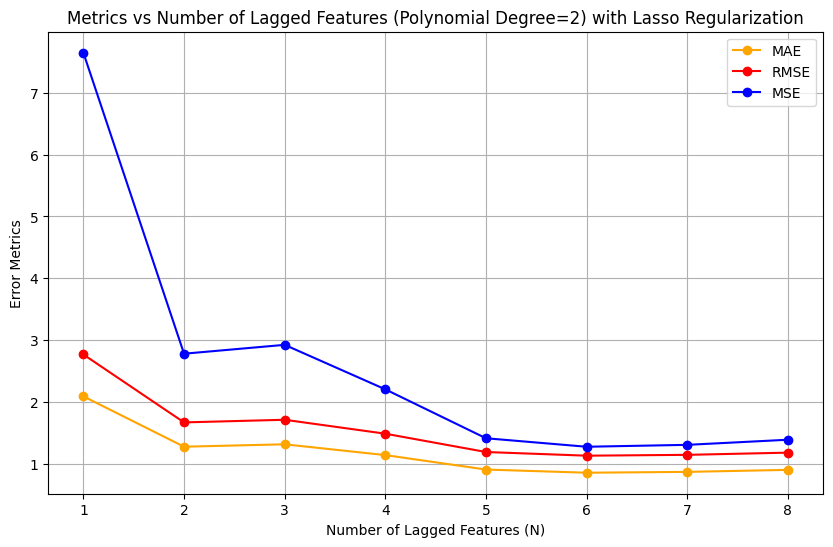


Metrics for Polynomial Degree 3:
   N  Mean Absolute Error  Root Mean Squared Error  Mean Squared Error
0  1             2.091817                 2.788201            7.774066
1  2             1.332737                 1.780427            3.169919
2  3             1.170838                 1.574023            2.477547
3  4             1.056047                 1.408427            1.983667
4  5             1.022791                 1.345307            1.809850
5  6             1.040215                 1.360687            1.851468
6  7             1.036570                 1.357100            1.841720
7  8             1.029415                 1.350895            1.824916


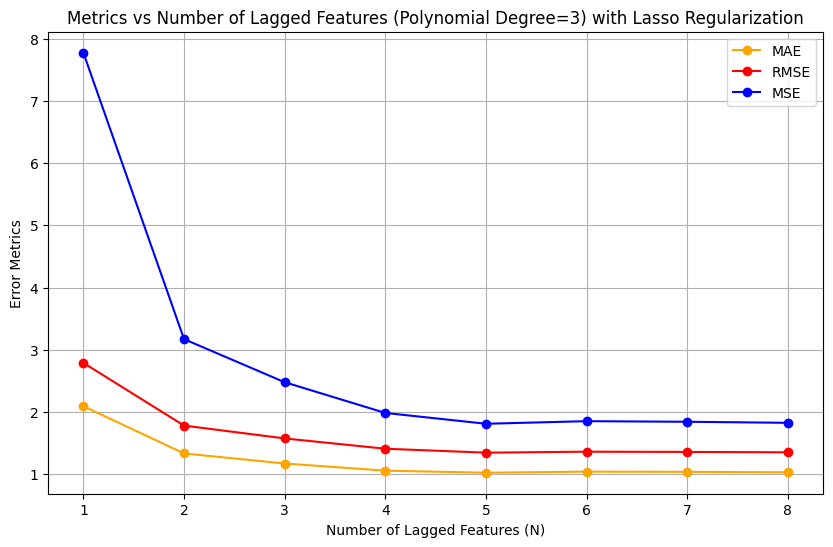

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.012e+05, tolerance: 2.706e+04
  model = cd_fast.enet_coordinate_descent(



Metrics for Polynomial Degree 4:
   N  Mean Absolute Error  Root Mean Squared Error  Mean Squared Error
0  1             2.097199                 2.781979            7.739410
1  2             1.276459                 1.693657            2.868473
2  3             1.208194                 1.610672            2.594264
3  4             1.176712                 1.546173            2.390650
4  5             1.180279                 1.543208            2.381491
5  6             1.100458                 1.444636            2.086973
6  7             1.075043                 1.414817            2.001708
7  8             1.070421                 1.411177            1.991420


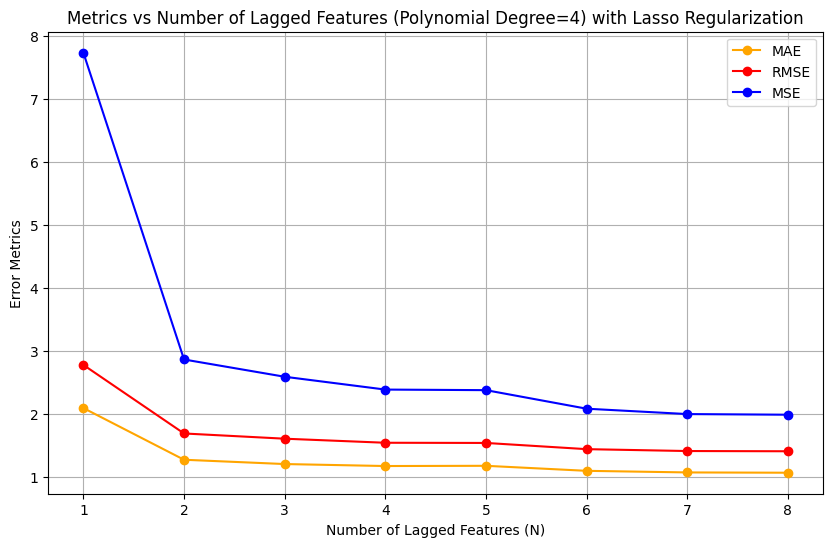

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.012e+05, tolerance: 2.674e+04
  model = cd_fast.enet_coordinate_descent(



Metrics for Polynomial Degree 5:
   N  Mean Absolute Error  Root Mean Squared Error  Mean Squared Error
0  1             2.093525                 2.778826            7.721876
1  2             1.326473                 1.747274            3.052965
2  3             1.287192                 1.692269            2.863773
3  4             1.257592                 1.644885            2.705648
4  5             1.160710                 1.528526            2.336392
5  6             1.104770                 1.458227            2.126426
6  7             1.083571                 1.432376            2.051700
7  8             1.063681                 1.405805            1.976286


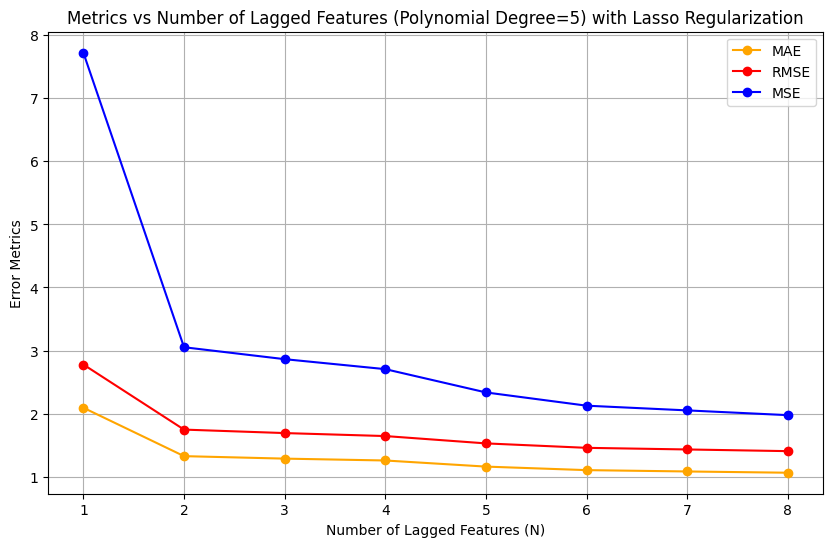

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.012e+05, tolerance: 2.641e+04
  model = cd_fast.enet_coordinate_descent(



Metrics for Polynomial Degree 6:
   N  Mean Absolute Error  Root Mean Squared Error  Mean Squared Error
0  1             2.090580                 2.777628            7.715217
1  2             1.380919                 1.814501            3.292414
2  3             1.312110                 1.719063            2.955179
3  4             1.236719                 1.626261            2.644724
4  5             1.144277                 1.512841            2.288688
5  6             1.106669                 1.465734            2.148375
6  7             1.068660                 1.412622            1.995502
7  8             1.090057                 1.436055            2.062253


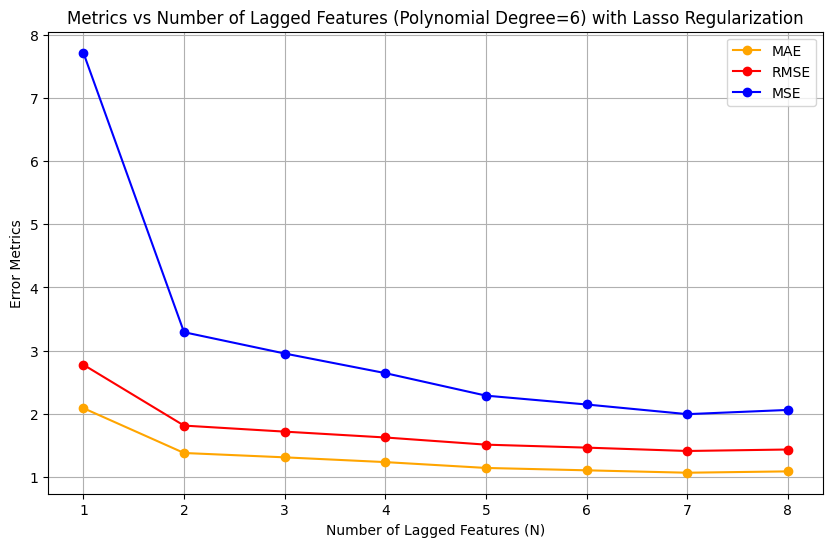

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.012e+05, tolerance: 2.609e+04
  model = cd_fast.enet_coordinate_descent(



Metrics for Polynomial Degree 7:
   N  Mean Absolute Error  Root Mean Squared Error  Mean Squared Error
0  1             2.090199                 2.778338            7.719163
1  2             1.413600                 1.857433            3.450059
2  3             1.282751                 1.685973            2.842504
3  4             1.200090                 1.585191            2.512831
4  5             1.157283                 1.531386            2.345143
5  6             1.088046                 1.439764            2.072919
6  7             1.087065                 1.431229            2.048418
7  8             1.123011                 1.476050            2.178724


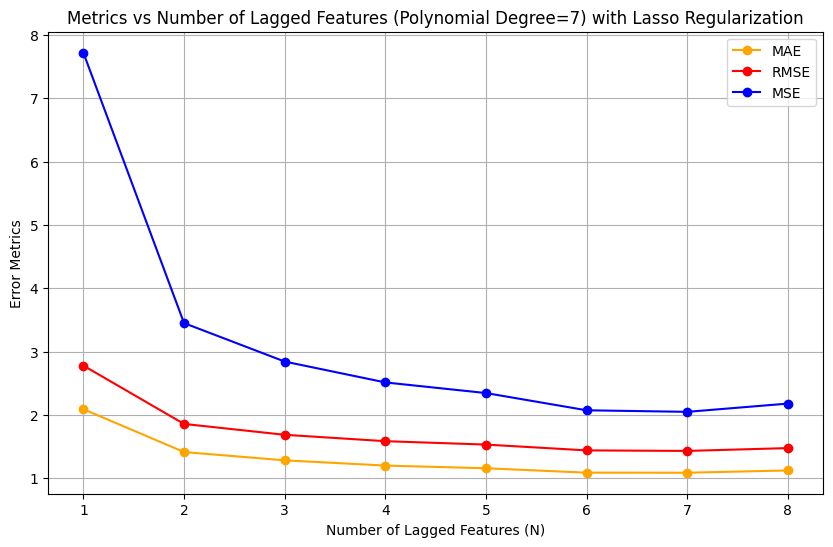

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.012e+05, tolerance: 2.575e+04
  model = cd_fast.enet_coordinate_descent(



Metrics for Polynomial Degree 8:
   N  Mean Absolute Error  Root Mean Squared Error  Mean Squared Error
0  1             2.090621                 2.778964            7.722643
1  2             1.401438                 1.844012            3.400379
2  3             1.251212                 1.651105            2.726148
3  4             1.200302                 1.586949            2.518407
4  5             1.163727                 1.540590            2.373417
5  6             1.090707                 1.437430            2.066204
6  7             1.111633                 1.460427            2.132848
7  8             1.132156                 1.489417            2.218362


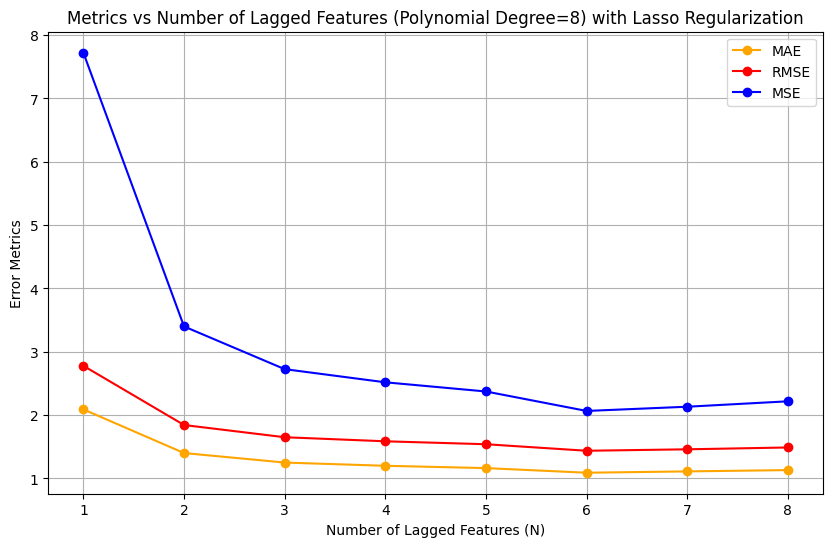

In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import GridSearchCV

# Create a function that trains and evaluates polynomial regression with Lasso for different lags (N)
def polynomial_regression_model_L1(degree, N, data):
    # Create N lagged features
    for i in range(1, N + 1):
        data[f'close_t-{i}'] = data['Close'].shift(i)

    # Drop NaN values
    data.dropna(inplace=True)

    # Create training set and validation set
    train_data = data[data['Date'] < '2024-01-01']  # Use previous years for training
    validation_data = data[data['Date'] >= '2024-01-01']  # Use year 2024 for validation

    # Prepare features (X) and target (y) for training and validation
    X_train = train_data[[f'close_t-{i}' for i in range(1, N + 1)]]
    y_train = train_data['Close']
    X_val = validation_data[[f'close_t-{i}' for i in range(1, N + 1)]]
    y_val = validation_data['Close']

    # Generate polynomial features
    poly = PolynomialFeatures(degree=degree)
    X_train_poly = poly.fit_transform(X_train)
    X_val_poly = poly.transform(X_val)

    # Define the parameter grid for GridSearchCV
    param_grid = {'alpha': [0.01, 0.1, 1, 10, 100]}  # Testing for different alpha values

    # Initialize GridSearchCV with Lasso model
    lasso = Lasso(max_iter=10000)

    # Perform grid search with cross-validation for selecting the best alpha value
    grid_search = GridSearchCV(lasso, param_grid, cv=5, scoring='neg_mean_squared_error')
    grid_search.fit(X_train, y_train)

    # Extract the best alpha from the grid search results
    alpha = grid_search.best_params_['alpha']
    #print(f"Best alpha value is: {alpha}")

    # Create and fit Lasso regression model using the training set and optimal alpha=0.01
    model = Lasso(alpha=alpha, max_iter=10000)
    model.fit(X_train_poly, y_train)

    # Make the prediction using the validation set
    y_pred = model.predict(X_val_poly)

    # Evaluate the model metrics
    mae = mean_absolute_error(y_val, y_pred)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    mse = mean_squared_error(y_val, y_pred)

    # Extract model parameters
    weights = model.coef_
    bias = model.intercept_

    return mae, rmse, mse, y_val, y_pred, validation_data['Date'], weights, bias

# Define parameters
num_tests = 8  # Testing for lags N = 1 to 8
max_degree = 8  # Testing for polynomial degree = 1 to 8

# Initialize figure for metrics comparison for each degree
all_results = []  # Collect results for all degrees

for degree in range(1, max_degree + 1):
    results = []

    for N in range(1, num_tests + 1):
        mae, rmse, mse, y_val, y_pred, dates, _, _ = polynomial_regression_model_L1(degree, N, df)
        results.append((N, mae, rmse, mse))

    # DataFrame for results
    results_df = pd.DataFrame(results, columns=['N', 'Mean Absolute Error', 'Root Mean Squared Error', 'Mean Squared Error'])
    all_results.append((degree, results_df))

    # Print metrics for this degree
    print(f"\nMetrics for Polynomial Degree {degree}:")
    print(results_df)

    # Plot all metrics in a single figure
    plt.figure(figsize=(10, 6))
    plt.plot(results_df['N'], results_df['Mean Absolute Error'], marker='o', linestyle='-', color='orange', label='MAE')
    plt.plot(results_df['N'], results_df['Root Mean Squared Error'], marker='o', linestyle='-', color='red', label='RMSE')
    plt.plot(results_df['N'], results_df['Mean Squared Error'], marker='o', linestyle='-', color='blue', label='MSE')

    plt.title(f'Metrics vs Number of Lagged Features (Polynomial Degree={degree}) with Lasso Regularization')
    plt.xlabel('Number of Lagged Features (N)')
    plt.ylabel('Error Metrics')
    plt.xticks(range(1, num_tests + 1))
    plt.legend()
    plt.grid(True)
    plt.show()

In [142]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Function to predict close prices for new dates
def predict_close_price(df, weights, bias, start_date, num_days, degree):
    # Create polynomial features object
    poly = PolynomialFeatures(degree=degree)

    predictions = []
    last_known_prices = df['Close'].values  # Last known 'close' prices

    # Get the last N close prices for initial prediction
    last_n_prices = last_known_prices[-N:]

    for _ in range(num_days):
        # Transform the last N prices into polynomial features
        last_n_prices_poly = poly.fit_transform(last_n_prices.reshape(1, -1))  # Reshape to 2D array

        # Calculate predicted close price for the next day
        predicted_close = np.dot(last_n_prices_poly, weights) + bias
        predictions.append(predicted_close[0])  # Append the scalar prediction

        # Update the last N prices for the next prediction
        last_n_prices = np.append(last_n_prices[1:], predicted_close)  # Shift and add new prediction

    return predictions

# Function that calculates the polynomial equation of the model
def print_polynomial_equation(weights, bias, degree, N):
    equation = f"Close_t = {bias}"

    # Create the polynomial terms dynamically based on N and degree
    feature_idx = 0
    for d in range(1, degree+1):  # Loop through degrees
        for i in range(N):  # Loop through lag values
            if d == 1:
                # Linear term (close_t-x)
                equation += f" + ({weights[feature_idx]}) * close_t-{i+1}"
            else:
                # Higher order terms (close_t-x^d)
                equation += f" + ({weights[feature_idx]}) * close_t-{i+1}^{d}"
            feature_idx += 1

    print(f"Polynomial Equation: {equation}\n")

# Train the model with the best value of lagged features, which is N=6 and best degree, which is 2
N = 3
degree = 2
_, _, _, _, _, _, weights, bias = polynomial_regression_model_L1(degree, N, df)
print_polynomial_equation(weights, bias, degree, N) # Print polynomial equation

# Predict the close price for the next day, which is 2024-11-15
start_date = '2024-11-15'
num_days = 1
next_day_prediction = predict_close_price(df, weights, bias, start_date, num_days, degree)
print(f"Predicted close price for {start_date}: {next_day_prediction[0]:.2f} $\n")

Polynomial Equation: Close_t = -1.6944255239573067 + (0.0) * close_t-1 + (1.2253155929207464) * close_t-2 + (-0.11838042088908574) * close_t-3 + (-0.09600913295369412) * close_t-1^2 + (0.00022868188044825716) * close_t-2^2 + (-6.374738561206139e-05) * close_t-3^2

Predicted close price for 2024-11-15: 316.72 $



In [111]:
# Make predictions starting for the next 15 days to see how the trend might evolve
num_days = 15
predictions = predict_close_price(df, weights, bias, start_date, num_days, degree)

# Print the predictions with the requested format
for i, prediction in enumerate(predictions, start=1):
    print(f"Predicted close price for day {i} ({start_date} + {i-1} days): {prediction:.2f} $")

Predicted close price for day 1 (2024-11-15 + 0 days): 316.75 $
Predicted close price for day 2 (2024-11-15 + 1 days): 321.39 $
Predicted close price for day 3 (2024-11-15 + 2 days): 323.43 $
Predicted close price for day 4 (2024-11-15 + 3 days): 315.61 $
Predicted close price for day 5 (2024-11-15 + 4 days): 322.72 $
Predicted close price for day 6 (2024-11-15 + 5 days): 325.59 $
Predicted close price for day 7 (2024-11-15 + 6 days): 313.52 $
Predicted close price for day 8 (2024-11-15 + 7 days): 324.46 $
Predicted close price for day 9 (2024-11-15 + 8 days): 328.54 $
Predicted close price for day 10 (2024-11-15 + 9 days): 309.97 $
Predicted close price for day 11 (2024-11-15 + 10 days): 326.88 $
Predicted close price for day 12 (2024-11-15 + 11 days): 332.68 $
Predicted close price for day 13 (2024-11-15 + 12 days): 304.18 $
Predicted close price for day 14 (2024-11-15 + 13 days): 330.34 $
Predicted close price for day 15 (2024-11-15 + 14 days): 338.63 $


###**Observation**
For lower degrees (from 1 to 4) MSE increases, indicating that very simple polynomial degrees may not capture the data patterns well. After degree 5, MSE begins to gradually decrease, and we observe a stabilization from degree 10 onwards, where MSE reaches lower and more consistent values. Thus, the optimal polynomial degree appears to be around 10. Increasing the degree beyond 10 does not lead to significant improvements in MSE, so a degree of 10 or slightly lower would likely provide a good balance between model complexity and accuracy.

###**Real TSLA stock closing prices from November 1st until November 24th**

##**Using L2-Normalization**


Metrics for Polynomial Degree 1:
   N  Mean Absolute Error  Root Mean Squared Error  Mean Squared Error
0  1             2.099360                 2.783271            7.746599
1  2             0.496907                 0.655248            0.429350
2  3             0.149196                 0.216338            0.046802
3  4             0.061188                 0.087807            0.007710
4  5             0.025778                 0.034509            0.001191
5  6             0.014406                 0.018347            0.000337


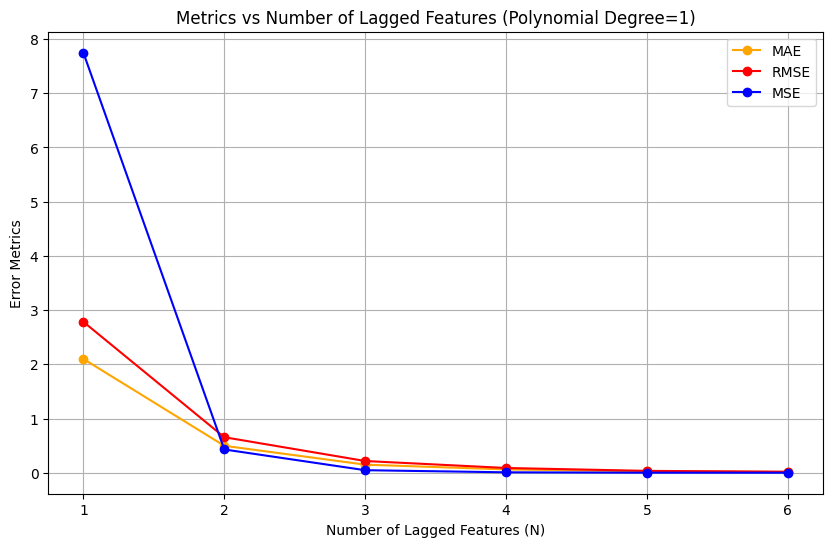

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=2.34588e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=7.83417e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=3.92168e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=2.35994e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T



Metrics for Polynomial Degree 2:
   N  Mean Absolute Error  Root Mean Squared Error  Mean Squared Error
0  1             2.086619                 2.765806            7.649683
1  2             0.664008                 0.861978            0.743006
2  3             0.167351                 0.244169            0.059619
3  4             0.067223                 0.095850            0.009187
4  5             0.030913                 0.039704            0.001576
5  6             0.020781                 0.027581            0.000761


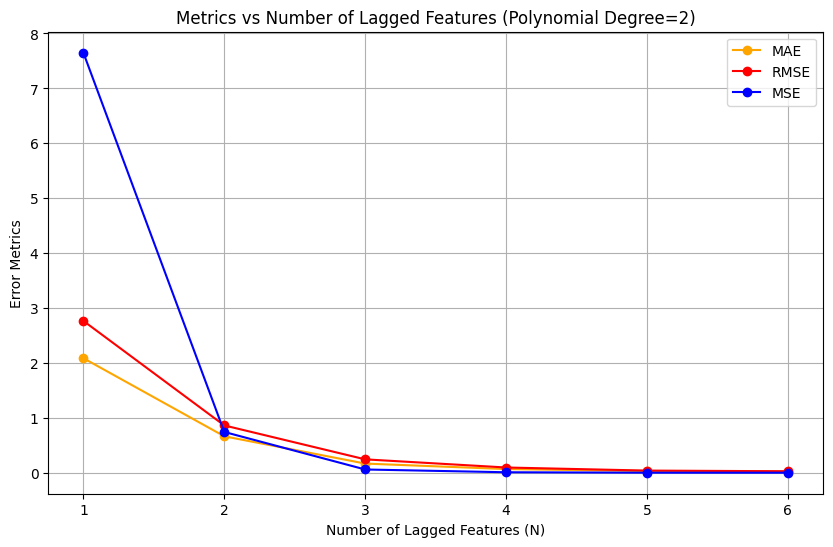

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.1584e-23): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=2.90653e-24): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.16541e-24): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T



Metrics for Polynomial Degree 3:
   N  Mean Absolute Error  Root Mean Squared Error  Mean Squared Error
0  1             2.094168                 2.789236            7.779837
1  2             0.540229                 0.723497            0.523448
2  3             0.155930                 0.229685            0.052755
3  4             0.064095                 0.091190            0.008316
4  5             0.029675                 0.040294            0.001624
5  6             0.021842                 0.028845            0.000832


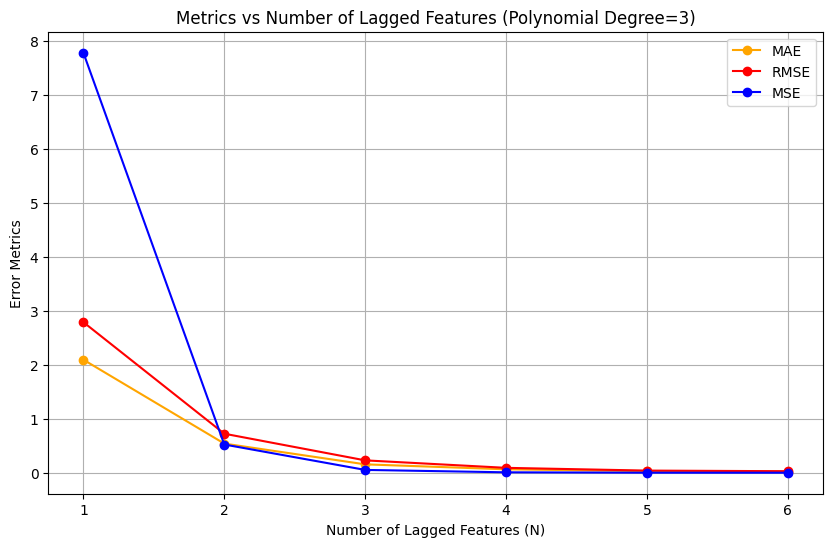

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=4.58533e-30): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=9.22679e-31): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T



Metrics for Polynomial Degree 4:
   N  Mean Absolute Error  Root Mean Squared Error  Mean Squared Error
0  1             2.097581                 2.782239            7.740856
1  2             0.506829                 0.670570            0.449664
2  3             0.162352                 0.239112            0.057175
3  4             0.060034                 0.081466            0.006637
4  5             0.033458                 0.047454            0.002252
5  6             0.024927                 0.037836            0.001432


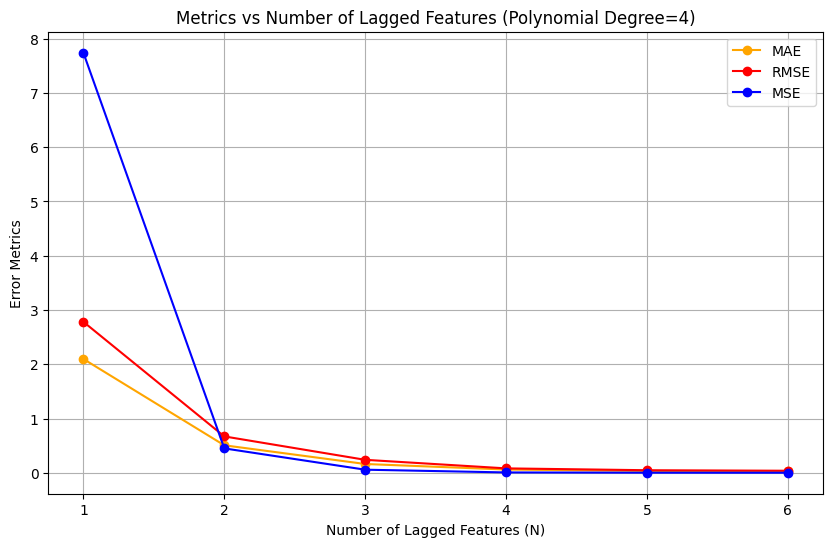

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.58834e-36): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=2.67095e-37): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T



Metrics for Polynomial Degree 5:
   N  Mean Absolute Error  Root Mean Squared Error  Mean Squared Error
0  1             2.088673                 2.777341            7.713621
1  2             0.514476                 0.680739            0.463405
2  3             0.284028                 0.459210            0.210874
3  4             2.758461                 2.964869            8.790445
4  5             2.042236                 2.555823            6.532231
5  6             2.030967                 2.676387            7.163047


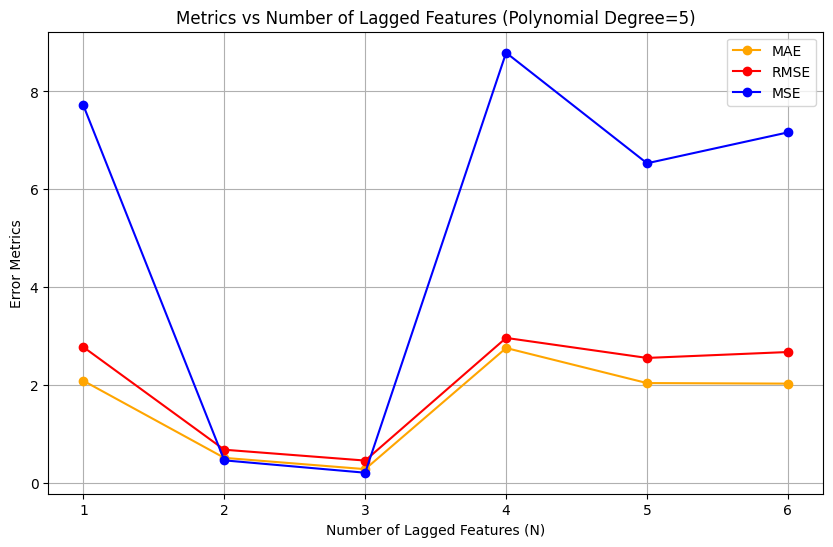

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=5.10617e-43): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T



Metrics for Polynomial Degree 6:
   N  Mean Absolute Error  Root Mean Squared Error  Mean Squared Error
0  1             2.092302                 2.781198            7.735060
1  2            25.933178                26.121158          682.314870
2  3            10.790954                12.761909          162.866317
3  4             4.897354                 6.083195           37.005265
4  5            72.249513                73.443357         5393.926678
5  6            21.885992                23.876539          570.089126


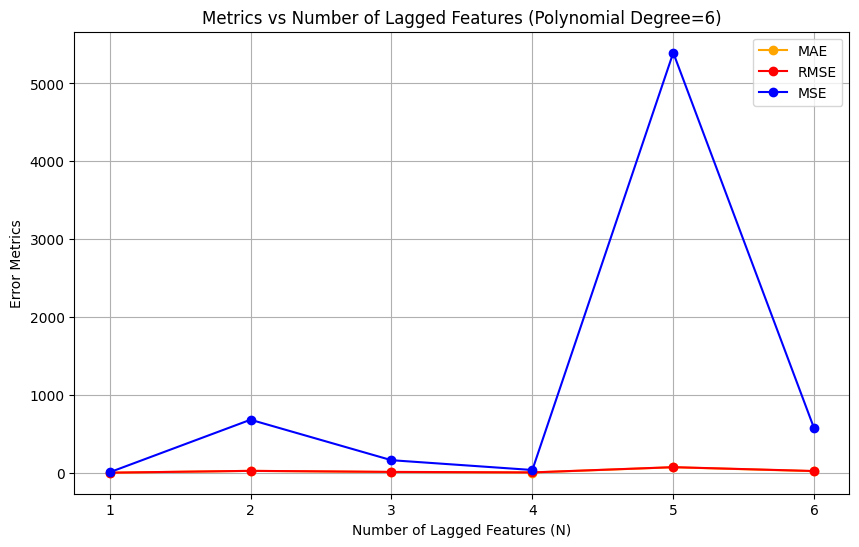

In [90]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Create a function that trains and evaluates polynomial regression with Ridge for different lags (N)
def polynomial_regression_model_L2(degree, N, data):
    # Create N lagged features
    for i in range(1, N + 1):
        data[f'close_t-{i}'] = data['Close'].shift(i)

    # Drop NaN values
    data.dropna(inplace=True)

    # Create training set and validation set
    train_data = data[data['Date'] < '2024-01-01']  # Use previous years for training
    validation_data = data[data['Date'] >= '2024-01-01']  # Use year 2024 for validation

    # Prepare features (X) and target (y) for training and validation
    X_train = train_data[[f'close_t-{i}' for i in range(1, N + 1)]]
    y_train = train_data['Close']
    X_val = validation_data[[f'close_t-{i}' for i in range(1, N + 1)]]
    y_val = validation_data['Close']

    # Generate polynomial features
    poly = PolynomialFeatures(degree=degree)
    X_train_poly = poly.fit_transform(X_train)
    X_val_poly = poly.transform(X_val)

    # Define the parameter grid for GridSearchCV
    param_grid = {'alpha': [0.01, 0.1, 1, 10, 100]}  # Testing for different alpha values

    # Initialize GridSearchCV with Lasso model
    lasso = Lasso(max_iter=10000)

    # Perform grid search with cross-validation for selecting the best alpha value
    grid_search = GridSearchCV(lasso, param_grid, cv=5, scoring='neg_mean_squared_error')
    grid_search.fit(X_train, y_train)

    # Extract the best alpha from the grid search results
    alpha = grid_search.best_params_['alpha']
    #print(f"Best alpha value is: {alpha}")

    # Create and fit Ridge regression model using the training set and optimal alpha=0.01
    model = Ridge(alpha=alpha, max_iter=10000)
    model.fit(X_train_poly, y_train)

    # Make the prediction using the validation set
    y_pred = model.predict(X_val_poly)

    # Evaluate the model metrics
    mae = mean_absolute_error(y_val, y_pred)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    mse = mean_squared_error(y_val, y_pred)

    # Extract model parameters
    weights = model.coef_
    bias = model.intercept_

    return mae, rmse, mse, y_val, y_pred, validation_data['Date'], weights, bias

# Define parameters
num_tests = 6  # Testing for lags N = 1 to 6
max_degree = 6  # Testing for degree = 1 to 6

# Initialize figure for metrics comparison for each degree
all_results = []  # Collect results for all degrees

for degree in range(1, max_degree + 1):
    results = []

    for N in range(1, num_tests + 1):
        mae, rmse, mse, y_val, y_pred, dates, _, _ = polynomial_regression_model_L2(degree, N, df)
        results.append((N, mae, rmse, mse))

    # DataFrame for results
    results_df = pd.DataFrame(results, columns=['N', 'Mean Absolute Error', 'Root Mean Squared Error', 'Mean Squared Error'])
    all_results.append((degree, results_df))

    # Print metrics for this degree
    print(f"\nMetrics for Polynomial Degree {degree}:")
    print(results_df)

    # Plot all metrics in a single figure
    plt.figure(figsize=(10, 6))
    plt.plot(results_df['N'], results_df['Mean Absolute Error'], marker='o', linestyle='-', color='orange', label='MAE')
    plt.plot(results_df['N'], results_df['Root Mean Squared Error'], marker='o', linestyle='-', color='red', label='RMSE')
    plt.plot(results_df['N'], results_df['Mean Squared Error'], marker='o', linestyle='-', color='blue', label='MSE')

    plt.title(f'Metrics vs Number of Lagged Features (Polynomial Degree={degree})')
    plt.xlabel('Number of Lagged Features (N)')
    plt.ylabel('Error Metrics')
    plt.xticks(range(1, num_tests + 1))
    plt.legend()
    plt.grid(True)
    plt.show()

In [143]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Function to predict close prices for new dates
def predict_close_price(df, weights, bias, start_date, num_days, degree):
    # Create polynomial features object
    poly = PolynomialFeatures(degree=degree)

    predictions = []
    last_known_prices = df['Close'].values  # Last known 'close' prices

    # Get the last N close prices for initial prediction
    last_n_prices = last_known_prices[-N:]

    for _ in range(num_days):
        # Transform the last N prices into polynomial features
        last_n_prices_poly = poly.fit_transform(last_n_prices.reshape(1, -1))  # Reshape to 2D array

        # Calculate predicted close price for the next day
        predicted_close = np.dot(last_n_prices_poly, weights) + bias
        predictions.append(predicted_close[0])  # Append the scalar prediction

        # Update the last N prices for the next prediction
        last_n_prices = np.append(last_n_prices[1:], predicted_close)  # Shift and add new prediction

    return predictions

# Train the model with the best value of lagged features, which is N=4 and optimal degree=3
N = 2
degree = 3
_, _, _, _, _, _, weights, bias = polynomial_regression_model_L2(degree, N, df)
print_polynomial_equation(weights, bias, degree, N) # Print polynomial equation

# Predict the close price for the next day, which is 2024-11-15
start_date = '2024-11-15'
num_days = 1
next_day_prediction = predict_close_price(df, weights, bias, start_date, num_days, degree)
print(f"Predicted close price for {start_date}: {next_day_prediction[0]:.2f} $\n")

Polynomial Equation: Close_t = 0.9774454765165501 + (0.0) * close_t-1 + (1.7798784662843194) * close_t-2 + (-0.7873954941125422) * close_t-1^2 + (0.0022266974854475785) * close_t-2^2 + (-0.004143612553255636) * close_t-1^3 + (0.0019328534061111631) * close_t-2^3

Predicted close price for 2024-11-15: 318.94 $



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=2.92798e-24): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
